### We will look at the effects of polynomial nonlinearities in classification accuracy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from estimator import RFClassifier, relu
from data_fns import noisy_sin_signal, data_matrix, butter_bandpass_filter
import dask

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

Client Scheduler: tcp://127.0.0.1:35903 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [3]:
def data_matrix_non_ov(series, label, N=40):
    ''' 
    From a time series, generate a n_sample x n_feature matrix using non-overlapping windows.
    
    Parameters
    ----------
    series: 1-D numpy array shape (M, 1)
    label: 1-D numpy array shape (M, 1)
    N: n_features of the data matrix
    
    Returns
    -------
    X: array of shape (M - N, N)
    y: array of shape (M - N, )
    '''
    X = np.array([series[N * i:N * (i + 1)] for i in range(int(len(series)/N))])
    y = label[N-1::N]
    return X, y  

In [4]:
def bp_weights(M, N, lowcut, highcut, fs):
    J = np.random.randn(M, N)
    J = butter_bandpass_filter(J, lowcut, highcut, fs)
    return J.T

def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

__First, we will generate data.__

In [71]:
# generate data
fs, dur, sig_dur, f_signal = 3000, 90, 0.05, 80
a = 0.01
signal, label = noisy_sin_signal(f_s=fs, dur=dur, sig_dur=sig_dur, f_signal=f_signal, a=a)

delta = 0.07
N = int(delta * 2000)
X, y = data_matrix_non_ov(signal, label, N)
idx = int(len(X) * 2 / 3)
X_train, y_train = X[:idx], y[:idx]
X_test, y_test = X[idx:], y[idx:]

In [72]:
n_features = sorted(set(np.logspace(0, 3, 20).astype('int')))
print(n_features)

[1, 2, 4, 6, 8, 12, 18, 26, 37, 54, 78, 112, 162, 233, 335, 483, 695, 1000]


__Let's look at the effect of using bp weights with different nonlinearities__

$h(x) = relu(x)$

In [73]:
%%time 
f = lambda M, N: bp_weights(M, N, lowcut=30, highcut=100, fs=2000)
# band pass features
results_bp = []
for n in n_features:
    params = {'width': n, 'weights': 'bandpass', 'weight_fun': f, 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_bp.append(dask.compute(*lazy_results))
mean_bp = 1 - np.mean(results_bp, axis=1)
std_bp = np.std(results_bp, axis=1)

CPU times: user 5.96 s, sys: 1.39 s, total: 7.35 s
Wall time: 31.5 s


$h(x) = x$

In [74]:
%%time 
f = lambda M, N: bp_weights(M, N, lowcut=30, highcut=100, fs=2000)
# band pass features
results_bp = []
for n in n_features:
    params = {'width': n, 'weights': 'bandpass', 'weight_fun': f, 'nonlinearity': lambda x: x}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_bp.append(dask.compute(*lazy_results))
mean_bp_x = 1 - np.mean(results_bp, axis=1)
std_bp_x = np.std(results_bp, axis=1)

CPU times: user 8.24 s, sys: 1.83 s, total: 10.1 s
Wall time: 47.6 s


$h(x)=x^2$

In [75]:
%%time 
f = lambda M, N: bp_weights(M, N, lowcut=30, highcut=100, fs=2000)
# band pass features
results_bp = []
for n in n_features:
    params = {'width': n, 'weights': 'bandpass', 'weight_fun': f, 'nonlinearity': lambda x: x ** 2}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_bp.append(dask.compute(*lazy_results))
mean_bp_x2 = 1 - np.mean(results_bp, axis=1)
std_bp_x2 = np.std(results_bp, axis=1)

CPU times: user 7.72 s, sys: 1.81 s, total: 9.54 s
Wall time: 44.1 s


$h(x) = x^3$

In [76]:
%%time 
f = lambda M, N: bp_weights(M, N, lowcut=30, highcut=100, fs=2000)
# band pass features
results_bp = []
for n in n_features:
    params = {'width': n, 'weights': 'bandpass', 'weight_fun': f, 'nonlinearity': lambda x: x ** 3}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_bp.append(dask.compute(*lazy_results))
mean_bp_x3 = 1 - np.mean(results_bp, axis=1)
std_bp_x3 = np.std(results_bp, axis=1)

CPU times: user 8.07 s, sys: 1.93 s, total: 10 s
Wall time: 46.7 s


In [77]:
%%time 
# h(x) = x^4
f = lambda M, N: bp_weights(M, N, lowcut=30, highcut=100, fs=2000)
# band pass features
results_bp = []
for n in n_features:
    params = {'width': n, 'weights': 'bandpass', 'weight_fun': f, 'nonlinearity': lambda x: x ** 4}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_bp.append(dask.compute(*lazy_results))
mean_bp_x4 = 1 - np.mean(results_bp, axis=1)
std_bp_x4 = np.std(results_bp, axis=1)

CPU times: user 8.83 s, sys: 2.12 s, total: 10.9 s
Wall time: 46.5 s


In [78]:
%%time 
# h(x) = x^5
f = lambda M, N: bp_weights(M, N, lowcut=30, highcut=100, fs=2000)
# band pass features
results_bp = []
for n in n_features:
    params = {'width': n, 'weights': 'bandpass', 'weight_fun': f, 'nonlinearity': lambda x: x ** 5}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_bp.append(dask.compute(*lazy_results))
mean_bp_x5 = 1 - np.mean(results_bp, axis=1)
std_bp_x5 = np.std(results_bp, axis=1)

CPU times: user 7.93 s, sys: 1.78 s, total: 9.71 s
Wall time: 44.7 s


In [79]:
%%time 
# h(x) = x^6
f = lambda M, N: bp_weights(M, N, lowcut=30, highcut=100, fs=2000)
# band pass features
results_bp = []
for n in n_features:
    params = {'width': n, 'weights': 'bandpass', 'weight_fun': f, 'nonlinearity': lambda x: x ** 6}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_bp.append(dask.compute(*lazy_results))
mean_bp_x6 = 1 - np.mean(results_bp, axis=1)
std_bp_x6 = np.std(results_bp, axis=1)

CPU times: user 7.86 s, sys: 1.84 s, total: 9.7 s
Wall time: 44.6 s


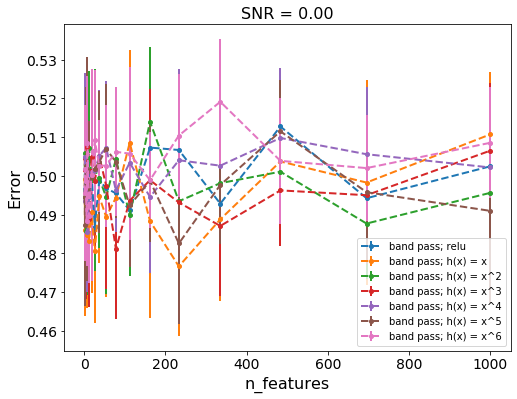

In [80]:
# plot
snr = a ** 2 / (1 - a ** 2)
fig = plt.figure(figsize=(8, 6))
plt.title('SNR = %0.2f' % snr, fontsize=16)
plt.errorbar(n_features, mean_bp, yerr=std_bp, fmt='--o', label='band pass; relu', markersize=4, lw=2)
plt.errorbar(n_features, mean_bp_x, yerr=std_bp_x, fmt='--o', label='band pass; h(x) = x', markersize=4, lw=2)
plt.errorbar(n_features, mean_bp_x2, yerr=std_bp_x2, fmt='--o', label='band pass; h(x) = x^2', markersize=4, lw=2)
plt.errorbar(n_features, mean_bp_x3, yerr=std_bp_x3, fmt='--o', label='band pass; h(x) = x^3', markersize=4, lw=2)
plt.errorbar(n_features, mean_bp_x4, yerr=std_bp_x4, fmt='--o', label='band pass; h(x) = x^4', markersize=4, lw=2)
plt.errorbar(n_features, mean_bp_x5, yerr=std_bp_x5, fmt='--o', label='band pass; h(x) = x^5', markersize=4, lw=2)
plt.errorbar(n_features, mean_bp_x6, yerr=std_bp_x6, fmt='--o', label='band pass; h(x) = x^6', markersize=4, lw=2)
plt.legend(fontsize=10)
plt.xlabel('n_features', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/rand_classification/non_ov_windows/polyn_nonlin_clf_a=%0.2f.png' % a)